In [1]:
import pickle

import joblib
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import (
    CountVectorizer,
    TfidfTransformer,
    TfidfVectorizer,
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load the dataset
data = pd.read_csv(
    r"C:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\model-1\training_data.csv"
)

In [3]:
# Update class-to-id mapping for 7 classes
label_mapping = {
    "No Hate/Toxic": 0,
    "Toxic 1": 1,
    "Toxic 2": 2,
    "Toxic 3": 3,
    "Hate 1": 4,
    "Hate 2": 5,
    "Hate 3": 6,
}
# Encode gold labels
data["Classification"] = data["Classification"].astype(str)
data["Classification"] = data["Classification"].map(label_mapping)
data["text"] = data["text"].astype(str)

In [4]:
# Divide features and labels
X = data["text"]
y = data["Classification"]

In [5]:
# Split dataset into training, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

### Text Processing Function ###

In [6]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download necessary NLTK data
nltk.download("punkt_tab")
nltk.download("wordnet")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    # Tokenization
    words = word_tokenize(text.lower())

    # Remove punctuation and non-alphabetic tokens
    words = [word for word in words if word.isalpha()]

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    return " ".join(words)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Preprocess the training and test data
X_train_proc = [preprocess(text) for text in X_train]
X_test_proc = [preprocess(text) for text in X_test]
X_valid_proc = [preprocess(text) for text in X_valid]

In [8]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vectorized = vectorizer.fit_transform(X_train_proc)

X_valid_vectorized = vectorizer.transform(X_valid_proc)
X_test_vectorized = vectorizer.transform(X_test_proc)

In [9]:
# save  vectorizer
joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']

In [9]:
print(y_train.value_counts())

Classification
4    15849
1    10568
0    10555
2     3894
5      677
3      302
6      155
Name: count, dtype: int64


In [10]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

target_count = 5000

oversampler = RandomOverSampler(
    sampling_strategy={
        3: target_count,  # Increase "Hate 3" to target_count
        6: target_count,  # Increase "Toxic 3" to target_count
        2: target_count,  # Increase "Hate 2" to target_count
        5: target_count,  # Increase "Toxic 2""
    },
    random_state=42,
)

X_train_oversampled, y_train_oversampled = oversampler.fit_resample(
    X_train_vectorized, y_train
)

# Then, apply RandomUnderSampler to reduce the majority class samples
undersampler = RandomUnderSampler(
    sampling_strategy={
        1: target_count,  # Reduce "Hate 1"
        4: target_count,  # Reduce "Toxic 1"
        0: target_count,  # Reduce "No Hate/Toxic"
    },
    random_state=42,
)

X_train_balanced, y_train_balanced = undersampler.fit_resample(
    X_train_oversampled, y_train_oversampled
)

# Check the new class distribution
print("Class distribution after balancing:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution after balancing:
Classification
0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
Name: count, dtype: int64


## Classification Models ##

### RidgeClassifierCV ###

In [14]:
# Train the classifier
cv = KFold(n_splits=5, shuffle=True, random_state=42)
clf = RidgeClassifierCV(alphas=(3.0, 4.0, 5.0, 6.0, 7.0), cv=cv)
clf.fit(X_train_balanced, y_train_balanced)

# Predict on the test data
y_pred_ridge = clf.predict(X_test_vectorized)

# Output the best alpha selected by RidgeClassifierCV
print("Best alpha chosen by RidgeClassifierCV:", clf.alpha_)

# Evaluate the predictions on test data
print("Test Accuracy: %s" % accuracy_score(y_test, y_pred_ridge))
print("Test F1-Score: %s" % f1_score(y_test, y_pred_ridge, average="weighted"))
print(
    "Test Classification Report:\n",
    classification_report(
        y_test, y_pred_ridge, target_names=list(label_mapping.keys())
    ),
)

# Predict on the validation data
y_val_pred_ridge = clf.predict(X_valid_vectorized)

# Evaluate the predictions on validation data
print("Validation Accuracy: %s" % accuracy_score(y_valid, y_val_pred_ridge))
print(
    "Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_ridge, average="weighted")
)
print(
    "Validation Classification Report:\n",
    classification_report(
        y_valid, y_val_pred_ridge, target_names=list(label_mapping.keys())
    ),
)

Best alpha chosen by RidgeClassifierCV: 3.0
Test Accuracy: 0.5054444444444445
Test F1-Score: 0.541725177155114
Test Classification Report:
                precision    recall  f1-score   support

No Hate/Toxic       0.58      0.63      0.60      2262
      Toxic 1       0.53      0.34      0.42      2265
      Toxic 2       0.30      0.44      0.36       834
      Toxic 3       0.05      0.37      0.09        65
       Hate 1       0.81      0.56      0.66      3396
       Hate 2       0.05      0.24      0.08       145
       Hate 3       0.03      0.24      0.05        33

     accuracy                           0.51      9000
    macro avg       0.33      0.40      0.32      9000
 weighted avg       0.61      0.51      0.54      9000

Validation Accuracy: 0.517
Validation F1-Score: 0.553367288603504
Validation Classification Report:
                precision    recall  f1-score   support

No Hate/Toxic       0.60      0.63      0.62      2262
      Toxic 1       0.55      0.35      

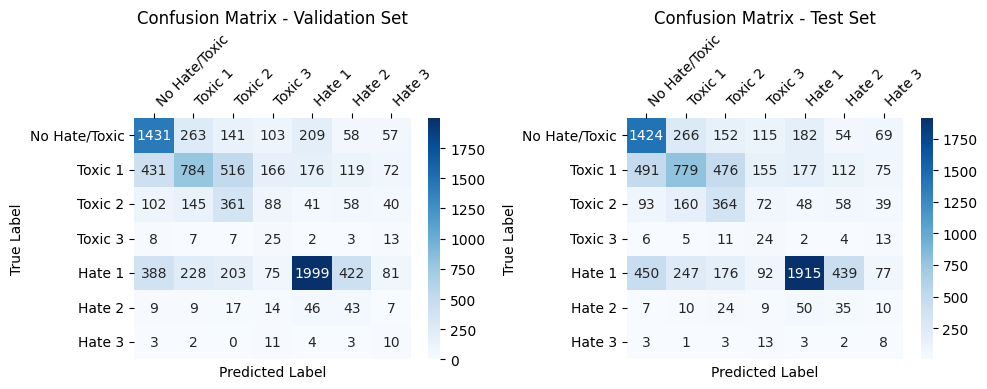

In [15]:
# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_ridge)
# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_ridge)
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the confusion matrix for validation set
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[0],
)
ax.set_title("Confusion Matrix - Validation Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

# Plot the confusion matrix for test set
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[1],
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

plt.tight_layout()
plt.show()

### XGBoost ###

In [16]:
xgb_clf = xgb.XGBClassifier(
    objective="multi:softmax",  # Multiclass classification
    num_class=7,  # Number of classes (7)
    eval_metric="mlogloss",  # Multiclass log-loss as evaluation metric
    use_label_encoder=False,  # Disable label encoding warning
)

# Define parameter grid for GridSearchCV
param_grid = {
    "xgb__max_depth": [5, 7],  # Control the complexity of the trees
    "xgb__learning_rate": [0.1, 0.2],  # Speed of model learning
    "xgb__n_estimators": [100, 200],  # Number of trees in the ensemble
    "xgb__subsample": [0.5, 0.7],  # Subsampling for robustness
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="accuracy",
    cv=2,  # 3-fold cross-validation for speed
    verbose=1,  # Show progress
    n_jobs=-1,  # Use all available cores
)

# Fit the grid search to the raw text data
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best parameters found by GridSearchCV
print("Best parameters found:", grid_search.best_params_)

# Predict on the test data using the best model
y_pred_best = grid_search.best_estimator_.predict(X_test_vectorized)

print("Test Accuracy: %s" % accuracy_score(y_test, y_pred_best))
print("Test F1-Score weighted: %s" % f1_score(y_test, y_pred_best, average="weighted"))
print(
    classification_report(y_test, y_pred_best, target_names=list(label_mapping.keys()))
)

# Predict on the validation set to evaluate performance
y_val_pred_best = grid_search.best_estimator_.predict(X_valid_vectorized)
print("Validation Accuracy: %s" % accuracy_score(y_valid, y_val_pred_best))
print(
    "Validation F1-Score weighted: %s"
    % f1_score(y_valid, y_val_pred_best, average="weighted")
)
print(
    classification_report(
        y_valid, y_val_pred_best, target_names=list(label_mapping.keys())
    )
)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:20:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder", "xgb__learning_rate", "xgb__max_depth", "xgb__n_estimators", "xgb__subsample" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters found: {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 100, 'xgb__subsample': 0.5}
Test Accuracy: 0.5415555555555556
Test F1-Score weighted: 0.5575475828679404
               precision    recall  f1-score   support

No Hate/Toxic       0.52      0.68      0.59      2262
      Toxic 1       0.51      0.38      0.44      2265
      Toxic 2       0.29      0.44      0.35       834
      Toxic 3       0.07      0.26      0.11        65
       Hate 1       0.83      0.61      0.70      3396
       Hate 2       0.07      0.14      0.10       145
       Hate 3       0.06      0.12      0.08        33

     accuracy                           0.54      9000
    macro avg       0.34      0.38      0.34      9000
 weighted avg       0.60      0.54      0.56      9000

Validation Accuracy: 0.543
Validation F1-Score weighted: 0.5574387812959115
               precision    recall  f1-score   support

No Hate/Toxic       0.53      0.69      0.60      2262
      T

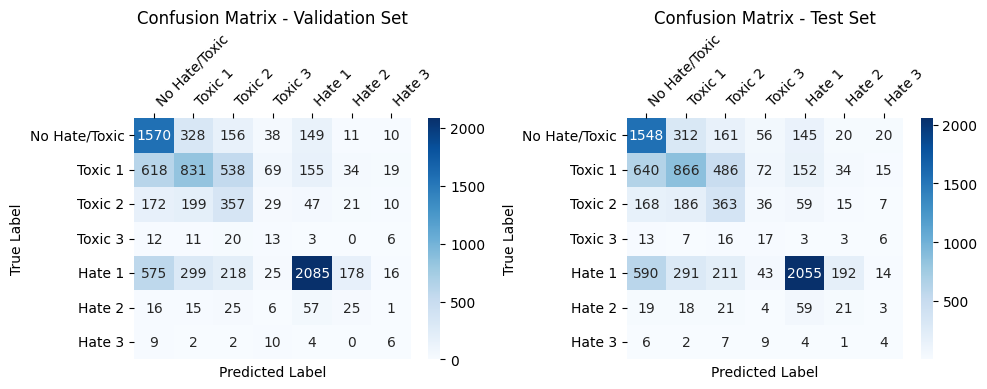

In [17]:
# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_best)
# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_best)
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot the confusion matrix for validation set
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[0],
)
ax.set_title("Confusion Matrix - Validation Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

# Plot the confusion matrix for test set
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[1],
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Naive Bayes Classifier ###

Multinomial Naive Bayes classifier - A generative classifier which models how a class could generate some input data. Given an observation, they return the class most likely to have generated the observation

In [12]:
# Initialize the Multinomial Naive Bayes classifier
nb = MultinomialNB()

nb.fit(X_train_vectorized, y_train)

# Predict on the test set
y_pred_nb = nb.predict(X_test_vectorized)
# Predict on the validation set
y_val_pred_nb = nb.predict(X_valid_vectorized)

# Evaluate the predictions
print("Test Accuracy: %s" % accuracy_score(y_pred_nb, y_test))
print("Test F1-Score: %s" % f1_score(y_test, y_pred_nb, average="weighted"))
print(classification_report(y_test, y_pred_nb, target_names=list(label_mapping.keys())))
print("Validation Accuracy: %s" % accuracy_score(y_val_pred_nb, y_valid))
print("Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_nb, average="weighted"))
print(
    classification_report(
        y_valid, y_val_pred_nb, target_names=list(label_mapping.keys())
    )
)

Test Accuracy: 0.5947777777777777
Test F1-Score: 0.5481345261588014
               precision    recall  f1-score   support

No Hate/Toxic       0.64      0.48      0.55      2262
      Toxic 1       0.54      0.54      0.54      2265
      Toxic 2       0.45      0.01      0.02       834
      Toxic 3       0.00      0.00      0.00        65
       Hate 1       0.61      0.89      0.72      3396
       Hate 2       0.00      0.00      0.00       145
       Hate 3       0.00      0.00      0.00        33

     accuracy                           0.59      9000
    macro avg       0.32      0.28      0.26      9000
 weighted avg       0.57      0.59      0.55      9000

Validation Accuracy: 0.6003333333333334
Validation F1-Score: 0.5541527075582181
               precision    recall  f1-score   support

No Hate/Toxic       0.68      0.49      0.57      2262
      Toxic 1       0.54      0.54      0.54      2264
      Toxic 2       0.64      0.02      0.03       835
      Toxic 3       0.0

c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined

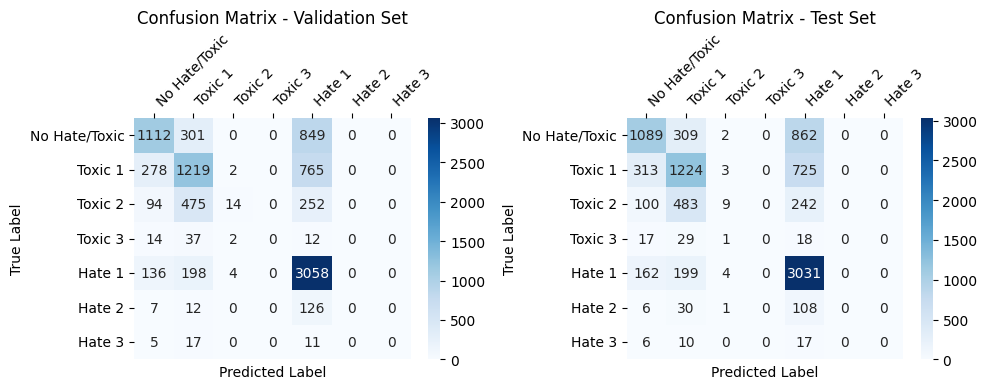

In [13]:
# Confusion matrix for the validation set
conf_matrix_val = confusion_matrix(y_valid, y_val_pred_nb)
# Confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_nb)
# Create subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # <-- Added this line

# Plot the confusion matrix for validation set
ax = sns.heatmap(
    conf_matrix_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[0],  # Specify the subplot
)
ax.set_title("Confusion Matrix - Validation Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

# Plot the confusion matrix for test set
ax = sns.heatmap(
    conf_matrix_test,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=list(label_mapping.keys()),
    yticklabels=list(label_mapping.keys()),
    ax=axes[1],  # Specify the subplot
)
ax.set_title("Confusion Matrix - Test Set")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.xaxis.set_ticks_position("top")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="left")

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

### Linear SVM ###

In [11]:
sgd = SGDClassifier(
    loss="hinge",
    penalty="l2",
    alpha=1e-3,
    random_state=42,
    max_iter=5,
    tol=None,
)

# Fit the model to the training data
sgd.fit(X_train_vectorized, y_train)

# Predict on the test set
y_pred_svm = sgd.predict(X_test_vectorized)
# Predict on the validation set
y_val_pred_svm = sgd.predict(X_valid_vectorized)

# Evaluate the predictions
print("Test Accuracy: %s" % accuracy_score(y_pred_svm, y_test))
print("Test F1-Score: %s" % f1_score(y_test, y_pred_svm, average="weighted"))
print(
    classification_report(y_test, y_pred_svm, target_names=list(label_mapping.keys()))
)
print("Validation Accuracy: %s" % accuracy_score(y_val_pred_svm, y_valid))
print("Validation F1-Score: %s" % f1_score(y_valid, y_val_pred_svm, average="weighted"))
print(
    classification_report(
        y_valid, y_val_pred_svm, target_names=list(label_mapping.keys())
    )
)

Test Accuracy: 0.5786666666666667
Test F1-Score: 0.530628239291586
               precision    recall  f1-score   support

No Hate/Toxic       0.62      0.48      0.54      2262
      Toxic 1       0.60      0.39      0.47      2265
      Toxic 2       0.52      0.06      0.11       834
      Toxic 3       0.17      0.02      0.03        65
       Hate 1       0.56      0.94      0.70      3396
       Hate 2       0.17      0.01      0.01       145
       Hate 3       0.00      0.00      0.00        33

     accuracy                           0.58      9000
    macro avg       0.38      0.27      0.27      9000
 weighted avg       0.57      0.58      0.53      9000

Validation Accuracy: 0.5813333333333334
Validation F1-Score: 0.5318258285347698
               precision    recall  f1-score   support

No Hate/Toxic       0.63      0.48      0.55      2262
      Toxic 1       0.60      0.38      0.47      2264
      Toxic 2       0.52      0.06      0.10       835
      Toxic 3       0.00

c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\OneDrive - National University of Singapore\Desktop\Y4S1\DSA4264\DSA4264-Detoxify\penv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined